In [ ]:
%tensorflow_version 1.x

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from sklearn.utils import shuffle

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'19lK2ZuvmN6LeHfpuYXd2tBNUD34rndFb'})
downloaded.GetContentFile('fer2013.csv')

In [ ]:
def getData(balance_ones = True , Ntest= 1000):
  X =[]
  Y =[]
  first = True
  for line in open('fer2013.csv'):
    if first:
      first = False
    else:
      row = line.split(',')
      Y.append(int(row[0]))
      X.append([int(p) for p in row[1].split()])
  
  X,Y = np.array(X)/255.0 , np.array(Y)
  X , Y = shuffle(X,Y)
  Xtrain , Ytrain = X[:-Ntest] , Y[:-Ntest]
  Xvalid , Yvalid = X[-Ntest:] , Y[-Ntest:]
  if balance_ones:
    X0,Y0 = Xtrain[Ytrain!=1, :] , Ytrain[Ytrain!=1]
    X1 = Xtrain[Ytrain==1, :]
    X1 = np.repeat(X1 , 9 , axis=0)
    Xtrain = np.vstack([X0,X1])
    Ytrain = np.concatenate((Y0 , [1]*len(X1)))
    return Xtrain , Ytrain , Xvalid , Yvalid

In [ ]:
def getImageData():
  Xtrain , Ytrain , Xvalid , Yvalid = getData()
  N,D = Xtrain.shape
  d = int(np.sqrt(D))
  Xtrain = Xtrain.reshape(-1,d,d,1)
  Xvalid = Xvalid.reshape(-1,d,d,1)
  return Xtrain , Ytrain , Xvalid , Yvalid

In [ ]:
def error_rate(targets , predictions):
  return np.mean(targets != predictions)

In [ ]:
def init_weight_and_bias(M1,M2):
  w = np.random.randn(M1,M2) / np.sqrt(M1)
  b = np.zeros(M2)
  return w.astype(np.float32) , b.astype(np.float32)

In [ ]:
def y2indicator(y):
  N = len(y)
  K = len(set(y))
  ind = np.zeros((N,K))
  for i in range(N):
    ind[i , y[i]] = 1
  return ind

In [ ]:
class HiddenLayer(object):
  def __init__(self,M1,M2,an_id):
    self.id = an_id
    self.M1 = M1
    self.M2 = M2
    w,b = init_weight_and_bias(M1,M2)
    self.w = tf.Variable(w.astype(np.float32))
    self.b = tf.Variable(b.astype(np.float32))
    self.params = [self.w , self.b]

  def forward(self,X):
    return tf.nn.relu(tf.matmul(X, self.w) + self.b)

In [ ]:
def init_filter(shape, poolsz):
  w = np.random.randn(*shape) *np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) +shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
  return w.astype(np.float32)

In [ ]:
class ConvPoolLayer(object):
  def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2,2)):
    sz = (fw, fh, mi, mo)
    W0 = init_filter(sz, poolsz)
    self.w = tf.Variable(W0)
    b0 = np.zeros(mo , dtype=np.float32)
    self.b = tf.Variable(b0)
    self.poolsz = poolsz
    self.params = [self.w, self.b]

  def forward(self, X):
    conv_out = tf.nn.conv2d(X, self.w, strides=[1,1,1,1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out , self.b)
    p1 , p2 = self.poolsz
    pool_out = tf.nn.max_pool(conv_out , ksize=[1,p1,p2,1] , strides=[1,p1,p2,1] , padding='SAME')
    return tf.nn.relu(pool_out)

In [ ]:
class CNN(object):
  def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
    self.convpool_layer_sizes = convpool_layer_sizes
    self.hidden_layer_sizes = hidden_layer_sizes

  def fit(self, X, Y, Xvalid, Yvalid, lr=1e-2, mu=0.9, reg=1e-3, decay=0.99999, eps=1e-10, batch_sz=30, epochs=5, show_fig=True):
    lr = np.float32(lr)
    mu = np.float32(mu)
    reg = np.float32(reg)
    decay = np.float32(decay)
    eps = np.float32(eps)
    k = len(set(Y))

    X,Y = shuffle(X,Y)
    X = X.astype(np.float32)
    Y = y2indicator(Y).astype(np.float32)
    Yvalid = y2indicator(Yvalid).astype(np.float32)
    Yvalid_flat = np.argmax(Yvalid , axis=1)

    N,width,hight,c = X.shape
    mi = c
    outw = width
    outh = hight
    self.convpool_layers = []

    for mo, fw, fh in self.convpool_layer_sizes:
      layer = ConvPoolLayer(mi, mo, fw, fh)
      self.convpool_layers.append(layer)
      outw = outw // 2
      outh = outh // 2
      mi = mo

    self.hidden_layers =[]
    M1 = self.convpool_layer_sizes[-1][0]*outw*outh
    count = 0

    for M2 in self.hidden_layer_sizes:
      h = HiddenLayer(M1, M2, count)
      self.hidden_layers.append(h)
      M1 = M2
      count += 1

    w,b = init_weight_and_bias(M1, k)
    self.w = tf.Variable(w, 'w_logreg')
    self.b = tf.Variable(b, 'b_logreg')

    self.params = [self.w, self.b]
    for h in self.convpool_layers:
      self.params += h.params
    for h in self.hidden_layers:
      self.params += h.params
        
    tfx = tf.placeholder(tf.float32 , shape=(None, width, hight, c), name='X')
    tfy = tf.placeholder(tf.float32, shape=(None, k), name='Y')

    act = self.forward(tfx)

    rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act, labels=tfy)) + rcost
    prediction = self.predict(tfx)

    train_op = tf.train.RMSPropOptimizer(lr, decay=decay , momentum=mu).minimize(cost)
    n_batches = N // batch_sz

    costs = []
    errors = []
    init = tf.global_variables_initializer()
        
    with tf.Session() as session:
      session.run(init)
      for i in range(epochs):
        X, Y = shuffle(X, Y)
        for j in range(n_batches):
          Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
          Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

          session.run(train_op, feed_dict={tfx: Xbatch, tfy: Ybatch})

          if j % 20 == 0:
            c = session.run(cost, feed_dict={tfx: Xvalid, tfy: Yvalid})
            costs.append(c)

            p = session.run(prediction, feed_dict={tfx: Xvalid, tfy: Yvalid})
            e = error_rate(Yvalid_flat, p)
            errors.append(e)
            print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

    if show_fig:
      fig , axes = plt.subplots(1,2,figsize=(12,4))
      axes[0].plot(costs, color='red')
      axes[0].set_title('Costs')
      axes[1].plot(errors, color='blue')
      axes[1].set_title('Error')

  def forward(self, X):
    Z = X
    
    for c in self.convpool_layers:
      Z = c.forward(Z)

    Z_shape = Z.get_shape().as_list()
    Z = tf.reshape(Z , [-1,np.prod(Z_shape[1:])])

    
    for h in self.hidden_layers:
      z = h.forward(Z)

    return tf.matmul(Z, self.w) + self.b

  def predict(self, X):
    py = self.forward(X)
    return tf.argmax(py, 1)

  def forw(self, X):
    Z = X
    N,width,hight,c = X.shape
    mi = c
    outw = width
    outh = hight
    self.convpool_layers = []

    for mo, fw, fh in self.convpool_layer_sizes:
      layer = ConvPoolLayer(mi, mo, fw, fh)
      self.convpool_layers.append(layer)
      outw = outw // 2
      outh = outh // 2
      mi = mo

    for c in self.convpool_layers:
      Z = c.forward(Z)

    Z_shape = Z.get_shape().as_list()
    Z = tf.reshape(Z , [-1,np.prod(Z_shape[1:])])

    self.hidden_layers =[]
    M1 = self.convpool_layer_sizes[-1][0]*outw*outh
    count = 0

    for M2 in self.hidden_layer_sizes:
      h = HiddenLayer(M1, M2, count)
      self.hidden_layers.append(h)
      M1 = M2
      count += 1

    w,b = init_weight_and_bias(M1, 7)
    self.w = tf.Variable(w, 'w_logreg')
    self.b = tf.Variable(b, 'b_logreg')

    for h in self.hidden_layers:
      z = h.forward(Z)

    return tf.matmul(Z, self.w) + self.b

  def pred(self,X):
    X = X.astype(np.float32)
    y = self.forw(X)
    return tf.argmax(y,1)


In [ ]:
def main():
  Xtrain , Ytrain , Xvalid , Yvalid = getImageData()
  #Xtrain = Xtrain.transpose((0,2,3,1))
  #Xvalid = Xvalid.transpose((0,2,3,1))

  model = CNN(convpool_layer_sizes=[(20,5,5), (20,5,5)], hidden_layer_sizes=[2880,2880])

  model.fit(Xtrain, Ytrain, Xvalid, Yvalid)

i: 0 j: 0 nb: 1305 cost: 4.847902 error rate: 0.74
i: 0 j: 20 nb: 1305 cost: 4.7712274 error rate: 0.739
i: 0 j: 40 nb: 1305 cost: 4.804065 error rate: 0.738
i: 0 j: 60 nb: 1305 cost: 4.773892 error rate: 0.76
i: 0 j: 80 nb: 1305 cost: 4.7495875 error rate: 0.74
i: 0 j: 100 nb: 1305 cost: 4.7237124 error rate: 0.739
i: 0 j: 120 nb: 1305 cost: 4.724881 error rate: 0.74
i: 0 j: 140 nb: 1305 cost: 4.703875 error rate: 0.759
i: 0 j: 160 nb: 1305 cost: 4.644496 error rate: 0.69
i: 0 j: 180 nb: 1305 cost: 4.673571 error rate: 0.699
i: 0 j: 200 nb: 1305 cost: 4.612228 error rate: 0.746
i: 0 j: 220 nb: 1305 cost: 4.6536474 error rate: 0.734
i: 0 j: 240 nb: 1305 cost: 4.5987983 error rate: 0.707
i: 0 j: 260 nb: 1305 cost: 4.5262833 error rate: 0.661
i: 0 j: 280 nb: 1305 cost: 4.5166707 error rate: 0.676
i: 0 j: 300 nb: 1305 cost: 4.5538816 error rate: 0.697
i: 0 j: 320 nb: 1305 cost: 4.529976 error rate: 0.713
i: 0 j: 340 nb: 1305 cost: 4.4578733 error rate: 0.662
i: 0 j: 360 nb: 1305 cost: 4.4

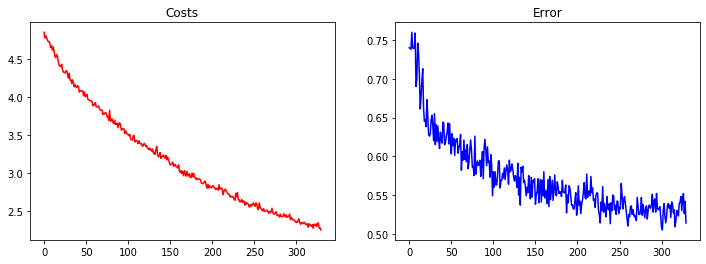

In [ ]:
if __name__=='__main__':
  main()

In [ ]:
Xt , Yt , Xv , Yv = getImageData()

In [ ]:
X , Y , xvl , yvl = getData()

In [ ]:
X.shape

(39167, 2304)

In [ ]:
Y.shape

(39167,)

In [ ]:
img = X[8].reshape(48,48)

In [ ]:
lab = ['Anger','Disgust','Fear','Happy','Sad','Surprise','Neutral']

Text(0.5, 1.0, 'Fear')

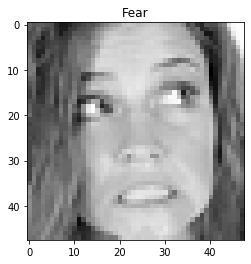

In [ ]:
plt.imshow(img,cmap='gray')
plt.title(lab[Y[8]])

In [ ]:
image = X[4].reshape(48,48,1)

In [ ]:
model = CNN(convpool_layer_sizes=[(20,5,5), (20,5,5)], hidden_layer_sizes=[2880,2880])

In [ ]:
img = X[8].reshape(-1,48,48,1)

In [ ]:
lab = Y[8]


In [ ]:
import pickle

In [ ]:
saved_model = pickle.dumps(model)

In [ ]:
model_from_pickle = pickle.loads(saved_model)

In [ ]:
pred = model_from_pickle.pred(X[52].reshape(-1,48,48,1))

In [ ]:
pred

<tf.Tensor 'ArgMax_6:0' shape=(1,) dtype=int64>

In [ ]:
Y[52]

4